<a href="https://colab.research.google.com/github/DulajHansana/Greenhouse-Fuzzy-Climate-Control-System/blob/main/Assignment_Fuzzy_Greenhouse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install scikit-fuzzy and import libraries
!pip -q install scikit-fuzzy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl

print("✅ Libraries installed and ready.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 14.0 MB/s eta 0:00:00
✅ Libraries installed and ready.


In [ ]:
# Define Plant Profiles (Part 1 of Assignment)
# Requirements: Minimum 3 plant species [cite: 16] with different ranges [cite: 18]
PLANTS = {
    "Tomato": {
        "Seedling":   {"T": 25.5, "H": 78},
        "Vegetative": {"T": 24.0, "H": 65},
        "Flowering":  {"T": 24.0, "H": 65},
    },
    "Lettuce": {
        "Seedling":   {"T": 19.0, "H": 70},
        "Vegetative": {"T": 16.0, "H": 60},
        "Flowering":  {"T": 20.0, "H": 60},
    },
    "Cucumber": {
        "Seedling":   {"T": 26.0, "H": 65},
        "Vegetative": {"T": 24.0, "H": 65},
        "Flowering":  {"T": 24.0, "H": 65},
    }
}

# Map text stages to numeric values (0-10 scale) for fuzzy input
STAGE_MAP = {"Seedling": 2.5, "Vegetative": 5.0, "Flowering": 8.5}
PLANT_LIST = list(PLANTS.keys())
STAGE_LIST = list(STAGE_MAP.keys())

print(f"✅ Loaded profiles for: {PLANT_LIST}")

✅ Loaded profiles for: ['Tomato', 'Lettuce', 'Cucumber']


In [ ]:
# Controller Builder (Part 2 & 3)
# Requirements: Mamdani [cite: 24] and Sugeno [cite: 25]
# Minimum 5 fuzzy sets per input [cite: 22]

TEMP_U = np.arange(0, 41, 1)
HUM_U  = np.arange(0, 101, 1)
STAGE_U = np.arange(0, 10.1, 0.1)
OUT_U  = np.arange(0, 101, 1)

# Sugeno Output Levels (Constant/Crisp)
SUGENO_LEVELS = {"Off": 0, "Low": 25, "Medium": 50, "High": 75, "Max": 100}

# Rule Base (30 Rules) - Requirement: At least 25 rules [cite: 26]
SUG_RULES = [
    # Temperature Rules
    (("t","VeryCold"), ("s","seed"), "High",   "Low"),
    (("t","VeryCold"), ("s","veg"),  "High",   "Off"),
    (("t","VeryCold"), ("s","flow"), "Max",    "Off"),
    (("t","Cold"),     ("s","seed"), "Medium", "Low"),
    (("t","Cold"),     ("s","veg"),  "Medium", "Off"),
    (("t","Cold"),     ("s","flow"), "High",   "Off"),
    (("t","Mild"),     ("s","seed"), "Low",    "Medium"),
    (("t","Mild"),     ("s","veg"),  "Off",    "Low"),
    (("t","Mild"),     ("s","flow"), "Off",    "Off"),
    (("t","Warm"),     ("s","seed"), "Medium", "High"),
    (("t","Warm"),     ("s","veg"),  "Low",    "Medium"),
    (("t","Warm"),     ("s","flow"), "Low",    "Low"),
    (("t","Hot"),      ("s","seed"), "High",   "High"),
    (("t","Hot"),      ("s","veg"),  "High",   "Medium"),
    (("t","Hot"),      ("s","flow"), "Max",    "Low"),
    # Humidity Rules
    (("h","VeryDry"),   ("s","seed"), "Low",    "Max"),
    (("h","VeryDry"),   ("s","veg"),  "Low",    "High"),
    (("h","VeryDry"),   ("s","flow"), "Off",    "Medium"),
    (("h","Dry"),       ("s","seed"), "Off",    "High"),
    (("h","Dry"),       ("s","veg"),  "Off",    "Medium"),
    (("h","Dry"),       ("s","flow"), "Off",    "Low"),
    (("h","Comfort"),   None,         "Off",    "Off"),
    (("h","Humid"),     ("s","veg"),  "Low",    "Off"),
    (("h","Humid"),     ("s","flow"), "Medium", "Off"),
    (("h","VeryHumid"), ("s","seed"), "Medium", "Off"),
    (("h","VeryHumid"), ("s","veg"),  "High",   "Off"),
    (("h","VeryHumid"), ("s","flow"), "High",   "Off"),
    # Safety Rules
    (("t","Hot"),   ("h","VeryHumid"), "Max",    "Off"),
    (("t","Cold"),  ("h","VeryDry"),   "Medium", "Medium"),
    (("t","Mild"),  ("h","Comfort"),   "Off",    "Off"),
]

def _mf_degree(mf, x, universe):
    return fuzz.interp_membership(universe, mf, x)

_CONTROLLER_CACHE = {}

def build_controller_pair(target_T, target_H, params=(0.0, 4.0, 0.0, 10.0)):
    # Adaptive Feature[cite: 35]: Shift membership functions based on target
    t_shift, t_width, h_shift, h_width = params

    mild_c = float(np.clip(target_T + t_shift, 10, 30))
    hum_c  = float(np.clip(target_H + h_shift, 25, 85))
    wT = float(np.clip(t_width, 2.5, 8.0))
    wH = float(np.clip(h_width, 6.0, 20.0))

    # --- Variables ---
    Temp  = ctrl.Antecedent(TEMP_U, 'Temp')
    Hum   = ctrl.Antecedent(HUM_U, 'Hum')
    Stage = ctrl.Antecedent(STAGE_U, 'Stage')
    Power = ctrl.Consequent(OUT_U, 'Power')
    Mist  = ctrl.Consequent(OUT_U, 'Mist')

    # Membership Functions
    Temp['VeryCold'] = fuzz.trapmf(TEMP_U, [0, 0, 8, 12])
    Temp['Cold']     = fuzz.trimf(TEMP_U, [mild_c-10, mild_c-6, mild_c-2])
    Temp['Mild']     = fuzz.trimf(TEMP_U, [mild_c-wT, mild_c, mild_c+wT])
    Temp['Warm']     = fuzz.trimf(TEMP_U, [mild_c+2, mild_c+6, mild_c+10])
    Temp['Hot']      = fuzz.trapmf(TEMP_U, [28, 32, 40, 40])

    Hum['VeryDry']   = fuzz.trapmf(HUM_U, [0, 0, 20, 30])
    Hum['Dry']       = fuzz.trimf(HUM_U, [hum_c-30, hum_c-20, hum_c-10])
    Hum['Comfort']   = fuzz.trimf(HUM_U, [hum_c-wH, hum_c, hum_c+wH])
    Hum['Humid']     = fuzz.trimf(HUM_U, [hum_c+5, hum_c+15, hum_c+25])
    Hum['VeryHumid'] = fuzz.trapmf(HUM_U, [80, 90, 100, 100])

    Stage['EarlySeedling'] = fuzz.trapmf(STAGE_U, [0, 0, 1.5, 2.5])
    Stage['Seedling']      = fuzz.trimf(STAGE_U, [1.5, 2.5, 3.5])
    Stage['Vegetative']    = fuzz.trimf(STAGE_U, [4.0, 5.0, 6.0])
    Stage['PreFlowering']  = fuzz.trimf(STAGE_U, [6.0, 7.0, 8.0])
    Stage['Flowering']     = fuzz.trapmf(STAGE_U, [7.5, 8.5, 10, 10])

    Power['Off']    = fuzz.trapmf(OUT_U, [0, 0, 5, 15])
    Power['Low']    = fuzz.trimf(OUT_U, [10, 25, 40])
    Power['Medium'] = fuzz.trimf(OUT_U, [35, 50, 65])
    Power['High']   = fuzz.trimf(OUT_U, [60, 75, 90])
    Power['Max']    = fuzz.trapmf(OUT_U, [85, 95, 100, 100])

    Mist['Off']    = fuzz.trapmf(OUT_U, [0, 0, 5, 15])
    Mist['Low']    = fuzz.trimf(OUT_U, [10, 25, 40])
    Mist['Medium'] = fuzz.trimf(OUT_U, [35, 50, 65])
    Mist['High']   = fuzz.trimf(OUT_U, [60, 75, 90])
    Mist['Max']    = fuzz.trapmf(OUT_U, [85, 95, 100, 100])

    # Mamdani Rules Construction (Standard)
    seed = Stage['EarlySeedling'] | Stage['Seedling']
    veg  = Stage['Vegetative']
    flow = Stage['PreFlowering'] | Stage['Flowering']

    rules = [
       ctrl.Rule(Temp['VeryCold'] & seed, (Power['High'], Mist['Low'])),
       ctrl.Rule(Temp['VeryCold'] & veg,  (Power['High'], Mist['Off'])),
       ctrl.Rule(Temp['VeryCold'] & flow, (Power['Max'],  Mist['Off'])),
       ctrl.Rule(Temp['Cold'] & seed,     (Power['Medium'], Mist['Low'])),
       ctrl.Rule(Temp['Cold'] & veg,      (Power['Medium'], Mist['Off'])),
       ctrl.Rule(Temp['Cold'] & flow,     (Power['High'],   Mist['Off'])),
       ctrl.Rule(Temp['Mild'] & seed,     (Power['Low'], Mist['Medium'])),
       ctrl.Rule(Temp['Mild'] & veg,      (Power['Off'], Mist['Low'])),
       ctrl.Rule(Temp['Mild'] & flow,     (Power['Off'], Mist['Off'])),
       ctrl.Rule(Temp['Warm'] & seed,     (Power['Medium'], Mist['High'])),
       ctrl.Rule(Temp['Warm'] & veg,      (Power['Low'],    Mist['Medium'])),
       ctrl.Rule(Temp['Warm'] & flow,     (Power['Low'],    Mist['Low'])),
       ctrl.Rule(Temp['Hot'] & seed,      (Power['High'], Mist['High'])),
       ctrl.Rule(Temp['Hot'] & veg,       (Power['High'], Mist['Medium'])),
       ctrl.Rule(Temp['Hot'] & flow,      (Power['Max'],  Mist['Low'])),
       ctrl.Rule(Hum['VeryDry'] & seed,   (Power['Low'], Mist['Max'])),
       ctrl.Rule(Hum['VeryDry'] & veg,    (Power['Low'], Mist['High'])),
       ctrl.Rule(Hum['VeryDry'] & flow,   (Power['Off'], Mist['Medium'])),
       ctrl.Rule(Hum['Dry'] & seed,       (Power['Off'], Mist['High'])),
       ctrl.Rule(Hum['Dry'] & veg,        (Power['Off'], Mist['Medium'])),
       ctrl.Rule(Hum['Dry'] & flow,       (Power['Off'], Mist['Low'])),
       ctrl.Rule(Hum['Comfort'],          (Power['Off'], Mist['Off'])),
       ctrl.Rule(Hum['Humid'] & veg,      (Power['Low'], Mist['Off'])),
       ctrl.Rule(Hum['Humid'] & flow,     (Power['Medium'], Mist['Off'])),
       ctrl.Rule(Hum['VeryHumid'] & seed, (Power['Medium'], Mist['Off'])),
       ctrl.Rule(Hum['VeryHumid'] & veg,  (Power['High'],   Mist['Off'])),
       ctrl.Rule(Hum['VeryHumid'] & flow, (Power['High'],   Mist['Off'])),
       ctrl.Rule(Temp['Hot'] & Hum['VeryHumid'], (Power['Max'], Mist['Off'])),
       ctrl.Rule(Temp['Cold'] & Hum['VeryDry'],  (Power['Medium'], Mist['Medium'])),
       ctrl.Rule(Temp['Mild'] & Hum['Comfort'],  (Power['Off'], Mist['Off'])),
    ]

    mam_system = ctrl.ControlSystem(rules)
    mam_sim = ctrl.ControlSystemSimulation(mam_system)

    # --- Sugeno Logic (Optimized Weighted Avg) ---
    sugeno_pack = {
        "Temp": {k: Temp[k].mf for k in Temp.terms},
        "Hum":  {k: Hum[k].mf for k in Hum.terms},
        "Stage":{k: Stage[k].mf for k in Stage.terms},
    }

    def sugeno_infer(t_val, h_val, s_val):
        t_deg = {k: _mf_degree(sugeno_pack["Temp"][k], t_val, TEMP_U) for k in ["VeryCold","Cold","Mild","Warm","Hot"]}
        h_deg = {k: _mf_degree(sugeno_pack["Hum"][k], h_val, HUM_U) for k in ["VeryDry","Dry","Comfort","Humid","VeryHumid"]}
        s_deg = {
            "seed": max(_mf_degree(sugeno_pack["Stage"]["EarlySeedling"], s_val, STAGE_U),
                        _mf_degree(sugeno_pack["Stage"]["Seedling"], s_val, STAGE_U)),
            "veg":  _mf_degree(sugeno_pack["Stage"]["Vegetative"], s_val, STAGE_U),
            "flow": max(_mf_degree(sugeno_pack["Stage"]["PreFlowering"], s_val, STAGE_U),
                        _mf_degree(sugeno_pack["Stage"]["Flowering"], s_val, STAGE_U)),
        }

        wsum = psum = msum = 0.0

        def get_w(cond):
            ctype, cname = cond
            if ctype == "t": return t_deg[cname]
            if ctype == "h": return h_deg[cname]
            if ctype == "s": return s_deg[cname]
            return 0.0

        for c1, c2, p_lab, m_lab in SUG_RULES:
            w = get_w(c1) if c2 is None else min(get_w(c1), get_w(c2))
            if w > 0:
                wsum += w
                psum += w * SUGENO_LEVELS[p_lab]
                msum += w * SUGENO_LEVELS[m_lab]

        if wsum == 0: return 0.0, 0.0
        return psum/wsum, msum/wsum

    return mam_sim, sugeno_infer

def get_controller(plant, stage, params=(0.0, 4.0, 0.0, 10.0)):
    # Cache system to prevent rebuilding slow controllers
    key = (plant, stage, tuple(np.round(params, 3)))
    if key in _CONTROLLER_CACHE:
        return _CONTROLLER_CACHE[key]

    target = PLANTS[plant][stage]
    mam, sug = build_controller_pair(target["T"], target["H"], params)
    _CONTROLLER_CACHE[key] = (mam, sug, target["T"], target["H"], STAGE_MAP[stage])
    return _CONTROLLER_CACHE[key]

print("✅ Controllers (Mamdani & Sugeno) built & cached.")

✅ Controllers (Mamdani & Sugeno) built & cached.


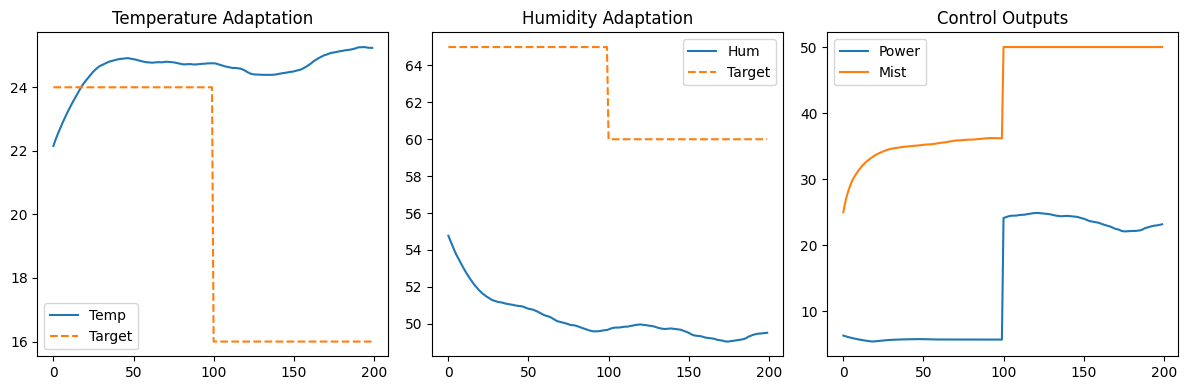

In [ ]:
# Simulation & Plots (Part 4)
# Requirement: Plot graphs of control outputs over time [cite: 37]
def simulate(plant, stage, controller="mamdani", steps=200, switch_at=None, switch_to=None, params=(0.0,4.0,0.0,10.0), seed=42):
    rng = np.random.default_rng(seed)
    T, H = 22.0, 55.0  # Initial State
    Tout, Hout = 25.0, 50.0 # Initial Weather
    curr_p, curr_s = plant, stage

    # Logs
    history = {"T":[], "H":[], "Power":[], "Mist":[], "TargetT":[], "TargetH":[]}

    for k in range(steps):
        # Dynamic Adaptation: Switch Plant
        if switch_at and k == switch_at:
            curr_p, curr_s = switch_to

        # Get Adaptive Controller
        mam, sug, tT, tH, sVal = get_controller(curr_p, curr_s, params)

        # Compute Output
        if controller == "mamdani":
            mam.input['Temp'] = T
            mam.input['Hum']  = H
            mam.input['Stage']= sVal
            mam.compute()
            power = mam.output['Power']
            mist  = mam.output['Mist']
        else:
            power, mist = sug(T, H, sVal)

        # Environment Physics (Simplified)
        Tout += rng.normal(0, 0.1)
        Hout += rng.normal(0, 0.2)

        # Update Greenhouse State
        # Heating/Cooling logic and Misting logic
        T += 0.05*(Tout - T) + 0.04*(power/100 * (-1 if T > tT else 1))
        H += 0.05*(Hout - H) + 0.1*(mist/100) - 0.02*(power/100)

        history["T"].append(T)
        history["H"].append(H)
        history["Power"].append(power)
        history["Mist"].append(mist)
        history["TargetT"].append(tT)
        history["TargetH"].append(tH)

    return history

# Run & Plot
res = simulate("Tomato", "Vegetative", controller="mamdani", steps=200, switch_at=100, switch_to=("Lettuce","Vegetative"))

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(res["T"], label="Temp")
plt.plot(res["TargetT"], '--', label="Target")
plt.title("Temperature Adaptation")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(res["H"], label="Hum")
plt.plot(res["TargetH"], '--', label="Target")
plt.title("Humidity Adaptation")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(res["Power"], label="Power")
plt.plot(res["Mist"], label="Mist")
plt.title("Control Outputs")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Performance Evaluation (Part 5)
# Requirement: 20 random tests [cite: 40]
# Requirement: Compare Avg Response Time, Avg Error, Energy, Smoothness

def get_response_time(arr, target, tolerance=1.0):
    # Calculates how many steps it takes to enter and stay within the tolerance band
    arr = np.array(arr)
    target = np.array(target)
    # Check where error is inside tolerance
    inside = np.abs(arr - target) < tolerance

    # If it never settles, return max steps
    if not np.any(inside):
        return len(arr)

    # Find the last time it was OUTSIDE. The next step is where it settled.
    # If it's always inside, index is 0.
    outside_indices = np.where(~inside)[0]
    if len(outside_indices) == 0:
        return 0
    return outside_indices[-1] + 1

def evaluate_metrics(res):
    # Error
    err = np.mean(np.abs(np.array(res["T"]) - np.array(res["TargetT"]))) + \
          np.mean(np.abs(np.array(res["H"]) - np.array(res["TargetH"])))

    # Energy
    energy = np.mean((np.array(res["Power"])/100)**2 + (np.array(res["Mist"])/100)**2)

    # Smoothness
    smooth = np.mean(np.abs(np.diff(res["Power"]))) + np.mean(np.abs(np.diff(res["Mist"])))

    # Response Time (Avg of Temp Response and Hum Response)
    rt_t = get_response_time(res["T"], res["TargetT"], tolerance=1.0)
    rt_h = get_response_time(res["H"], res["TargetH"], tolerance=2.0)
    rt = (rt_t + rt_h) / 2.0

    return err, energy, smooth, rt

results = []
rng = np.random.default_rng(42)

print("Running 20 simulations... (please wait)")
for i in range(20):
    p1, s1 = rng.choice(PLANT_LIST), rng.choice(STAGE_LIST)
    p2, s2 = rng.choice(PLANT_LIST), rng.choice(STAGE_LIST)
    sw = rng.integers(50, 150)

    # Run Mamdani
    r_m = simulate(p1, s1, "mamdani", 200, sw, (p2, s2), seed=i)
    e_m, en_m, sm_m, rt_m = evaluate_metrics(r_m)

    # Run Sugeno
    r_s = simulate(p1, s1, "sugeno", 200, sw, (p2, s2), seed=i)
    e_s, en_s, sm_s, rt_s = evaluate_metrics(r_s)

    results.append({
        "Run": i+1,
        "M_Err": e_m, "S_Err": e_s,
        "M_Energy": en_m, "S_Energy": en_s,
        "M_Smooth": sm_m, "S_Smooth": sm_s,
        "M_Time": rt_m, "S_Time": rt_s
    })

df = pd.DataFrame(results)
summary = pd.DataFrame({
    "Metric": ["Avg Response Time", "Avg Error", "Energy Usage", "Smoothness"],
    "Mamdani": [df["M_Time"].mean(), df["M_Err"].mean(), df["M_Energy"].mean(), df["M_Smooth"].mean()],
    "Sugeno":  [df["S_Time"].mean(), df["S_Err"].mean(), df["S_Energy"].mean(), df["S_Smooth"].mean()]
})

display(summary)

Running 20 simulations... (please wait)


,Metric,Mamdani,Sugeno
0,Avg Response Time,178.650000,179.075000
1,Avg Error,16.253654,16.316926
2,Energy Usage,0.217580,0.194742
3,Smoothness,0.350957,0.386429


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Mamdani'].plot(kind='hist', bins=20, title='Mamdani')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Sugeno'].plot(kind='hist', bins=20, title='Sugeno')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('Metric').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='index', y='Mamdani', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Mamdani', y='Sugeno', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Mamdani']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Metric')):
  _plot_series(series, series_name, i)
  fig.legend(title='Metric', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Mamdani')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['Sugeno']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Metric')):
  _plot_series(series, series_name, i)
  fig.legend(title='Metric', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('Sugeno')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Metric')):
  _plot_series(series, series_name, i)
  fig.legend(title='Metric', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_9['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Mamdani'].plot(kind='line', figsize=(8, 4), title='Mamdani')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['Sugeno'].plot(kind='line', figsize=(8, 4), title='Sugeno')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_12['Metric'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_12, x='index', y='Metric', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['Metric'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='Mamdani', y='Metric', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['Metric'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='Sugeno', y='Metric', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=summary)

https://docs.google.com/spreadsheets/d/1PrT-_MFcihy7npI_xP9JGG5dgrv3TQDJzMVLzgfnzF0/edit#gid=0


In [ ]:
# PSO Optimization (Part 6)
# Requirement: Optimize parameters and show before vs after [cite: 44]

# Objective: Minimize Error + 0.5*Energy
def objective(params):
    # Run a quick sugeno simulation (fast) for optimization
    hist = simulate("Tomato", "Vegetative", "sugeno", 150, 75, ("Lettuce","Vegetative"), params=params, seed=10)
    e, en, sm, rt = evaluate_metrics(hist)
    return e + 0.5*en

# Simple PSO
particles = np.random.uniform(-2, 2, (10, 4)) + [0, 4, 0, 10] # [t_shift, t_width, h_shift, h_width]
best_global = particles[0]
best_score = float('inf')

print("Optimizing parameters using PSO...")
for i in range(15): # 15 Iterations
    scores = [objective(p) for p in particles]
    min_idx = np.argmin(scores)
    if scores[min_idx] < best_score:
        best_score = scores[min_idx]
        best_global = particles[min_idx]

    # Move particles towards best (simplified)
    center = particles[min_idx]
    particles += 0.1 * (center - particles) + np.random.normal(0, 0.1, particles.shape)

print(f"✅ Optimization Complete.")
print(f"Best Params: {best_global}")

# Before vs After Comparison
base_res = simulate("Tomato", "Vegetative", "mamdani", 200, 100, ("Lettuce","Vegetative"), params=(0,4,0,10))
opt_res  = simulate("Tomato", "Vegetative", "mamdani", 200, 100, ("Lettuce","Vegetative"), params=tuple(best_global))

b_e, b_en, b_sm, b_rt = evaluate_metrics(base_res)
a_e, a_en, a_sm, a_rt = evaluate_metrics(opt_res)

comp_table = pd.DataFrame({
    "Metric": ["Avg Response Time", "Avg Error", "Energy Usage"],
    "Before": [b_rt, b_e, b_en],
    "After":  [a_rt, a_e, a_en]
})
display(comp_table)

Optimizing parameters using PSO...
✅ Optimization Complete.
Best Params: [-2.22282124  3.74824304  1.38752556 11.83741558]


,Metric,Before,After
0,Avg Response Time,200.000000,200.000000
1,Avg Error,16.992331,16.969873
2,Energy Usage,0.214313,0.206586


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=comp_table)

https://docs.google.com/spreadsheets/d/10uvOSy9eZMfSUGjzq8aljfUP9yZJtbn0niLyZQMi2x4/edit#gid=0


In [ ]:

import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# -- GUI Elements --
style = {'description_width': 'initial'}

# Dropdowns for Plant/Stage
plant_dd = widgets.Dropdown(options=["Tomato", "Lettuce", "Cucumber"], value="Tomato", description="Plant:")
stage_dd = widgets.Dropdown(options=["Seedling", "Vegetative", "Flowering"], value="Vegetative", description="Stage:")

# Sliders for Environment (Inputs)
temp_slider = widgets.FloatSlider(min=0, max=40, step=0.5, value=22.0, description="Internal Temp (°C):", style=style)
hum_slider  = widgets.FloatSlider(min=0, max=100, step=1.0, value=55.0, description="Internal Humidity (%):", style=style)

# Output Display
out = widgets.Output()

def update_gui(change=None):
    with out:
        clear_output(wait=True)

        # Get current values
        p = plant_dd.value
        s = stage_dd.value
        T = temp_slider.value
        H = hum_slider.value

        # Get Controller & Compute
        # (Using the get_controller function from your main code)
        mam, sug, tT, tH, sVal = get_controller(p, s)

        mam.input['Temp'] = T
        mam.input['Hum']  = H
        mam.input['Stage']= sVal
        mam.compute()

        pow_val = mam.output['Power']
        mist_val = mam.output['Mist']

        # Visual Dashboard
        fig, ax = plt.subplots(figsize=(10, 3))
        ax.axis('off')

        # Text Info
        ax.text(0.0, 0.8, f"Target Temp: {tT}°C", fontsize=12, color='green')
        ax.text(0.0, 0.6, f"Target Hum:  {tH}%", fontsize=12, color='green')

        ax.text(0.3, 0.8, f"Current Temp: {T}°C", fontsize=12, color='blue')
        ax.text(0.3, 0.6, f"Current Hum:  {H}%", fontsize=12, color='blue')

        # Action Bars
        ax.text(0.6, 0.8, f"HEATER/FAN POWER: {pow_val:.1f}%", fontsize=12, fontweight='bold')
        ax.barh(0.85, pow_val, height=0.1, left=0.6, color='red', align='center')

        ax.text(0.6, 0.4, f"MISTING SYSTEM: {mist_val:.1f}%", fontsize=12, fontweight='bold')
        ax.barh(0.45, mist_val, height=0.1, left=0.6, color='cyan', align='center')

        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        plt.show()

# Link events
plant_dd.observe(update_gui, names='value')
stage_dd.observe(update_gui, names='value')
temp_slider.observe(update_gui, names='value')
hum_slider.observe(update_gui, names='value')

# Display
display(widgets.VBox([widgets.HBox([plant_dd, stage_dd]),
                      widgets.HBox([temp_slider, hum_slider])]))
display(out)
update_gui() # Initial draw

Output()

In [ ]:

import random

# 1. Define RL Environment
class GreenhouseEnv:
    def __init__(self, target_t, target_h):
        self.t = 20.0 # Start temp
        self.h = 50.0 # Start hum
        self.target_t = target_t
        self.target_h = target_h

    def step(self, action):
        # Action: 0=Nothing, 1=Heat, 2=Cool, 3=Mist, 4=Dehumidify
        power = 0
        mist = 0

        if action == 1: self.t += 1.0; power=50
        if action == 2: self.t -= 1.0; power=50
        if action == 3: self.h += 2.0; mist=50
        if action == 4: self.h -= 2.0; power=20

        # Calculate Reward (Negative Error + Energy Penalty)
        err = abs(self.t - self.target_t) + abs(self.h - self.target_h)
        energy = (power + mist) / 100
        reward = -err - (0.1 * energy)

        # State: Discretized Temp/Hum difference
        t_state = int(self.t - self.target_t)
        h_state = int(self.h - self.target_h)
        next_state = (t_state, h_state)

        return next_state, reward

# 2. Q-Learning Algorithm
q_table = {} # Stores "Learned Rules"
actions = [0, 1, 2, 3, 4] # Available moves
alpha = 0.1  # Learning Rate
gamma = 0.9  # Discount Factor
epsilon = 0.1 # Exploration rate

env = GreenhouseEnv(target_t=24.0, target_h=65.0)

print("Training RL Agent to learn rules... (1000 Episodes)")

for episode in range(1000):
    state = (0, 0) # Start at target
    env.t, env.h = 24.0, 65.0 # Reset

    for _ in range(50): # 50 steps per episode
        # Choose Action (Explore vs Exploit)
        if random.uniform(0, 1) < epsilon:
            action = random.choice(actions)
        else:
            action = max(actions, key=lambda a: q_table.get((state, a), 0.0))

        # Take Action
        next_state, reward = env.step(action)

        # Update Q-Value (The "Brain")
        old_q = q_table.get((state, action), 0.0)
        next_max = max([q_table.get((next_state, a), 0.0) for a in actions])
        new_q = old_q + alpha * (reward + gamma * next_max - old_q)
        q_table[(state, action)] = new_q

        state = next_state

print("✅ Training Complete.")

# 3. Test the Learned "Rules"
print("\n--- Testing RL Agent's Learned Rules ---")
test_env = GreenhouseEnv(target_t=24.0, target_h=65.0)
test_env.t = 20.0 # Start Cold
test_env.h = 50.0 # Start Dry

print(f"Start: Temp={test_env.t}, Hum={test_env.h}")
for i in range(5):
    state = (int(test_env.t - 24), int(test_env.h - 65))
    action = max(actions, key=lambda a: q_table.get((state, a), 0.0))
    action_name = ["Wait", "Heat", "Cool", "Mist", "Dry"][action]
    test_env.step(action)
    print(f"Step {i+1}: Action={action_name} -> New Temp={test_env.t}, New Hum={test_env.h}")

Training RL Agent to learn rules... (1000 Episodes)
✅ Training Complete.

--- Testing RL Agent's Learned Rules ---
Start: Temp=20.0, Hum=50.0
Step 1: Action=Wait -> New Temp=20.0, New Hum=50.0
Step 2: Action=Wait -> New Temp=20.0, New Hum=50.0
Step 3: Action=Wait -> New Temp=20.0, New Hum=50.0
Step 4: Action=Wait -> New Temp=20.0, New Hum=50.0
Step 5: Action=Wait -> New Temp=20.0, New Hum=50.0
